# Face Generation

This is project 5 of the Udacity course ("Nanodegree programme") "Deep Learning Foundations"

As the output of the project is too large, I'll present the main results without actually running the code.

Two datasets are used in this project:
- MNIST
- CelebA

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

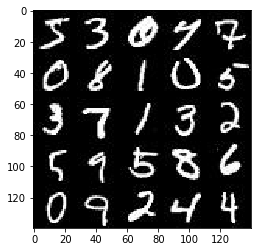

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

# CelebA

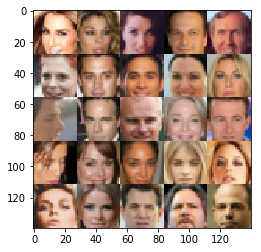

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
import warnings
import tensorflow as tf
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_img') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    

    return inputs_img, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


First I start with the simplest possible model - just one dense layer both in generator and discriminator:

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    n_units=128
    alpha=0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        images_flat = tf.contrib.layers.flatten(images)
        h1 = tf.layers.dense(images_flat, n_units, activation=None)
        
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.01
    n_units=128
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, 28*28*out_channel_dim, activation=None)
        out_flat = tf.tanh(logits)
        out = tf.reshape(out_flat, shape = [tf.shape(out_flat)[0], 28, 28, out_channel_dim])
        
        return out
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In fact, alpha is a hyper-parameter which should be tuned. So it must be passed as an argument to the generator and discriminator. Unfortunately it is not. So I had to dive into the functions and change alpha when training the models. Another option - to make alpha global seems even a worse choice.

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


The tensorflow documentation [suggests](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization) to use dependencies for batch normalization. I do not fully understand what it means so I just copied tf.control_dependencies from here: https://discussions.udacity.com/t/generator-loss-is-bigger-than-discriminator-loss-generated-images-are-poor-quality/312533/2

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Borrowed from:
    # https://discussions.udacity.com/t/generator-loss-is-bigger-than-discriminator-loss-generated-images-are-poor-quality/312533/2
    # https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples = []
    losses = []
    steps = 0
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

Probably you noticed some cheating: I use learning_rate as a float variable which I get from arguments of the train function. It is not a tensor (tf.float32). I tried to use learn_rate produced by model_inputs in several ways each time I got some Error. So I used learning_rate instead. Training the models takes a lot of time. I could not afford to spend time on this issue. Some day (down the road) I'll learn how to tackle the issue, but not today. At the end of the day, this is the project on GANs , not on transfer of parameters into a tf model.

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

I do not show how the model works on a MNIST data set. In fact, it works badly. It produces some blurry images even after 3 epochs, like this:

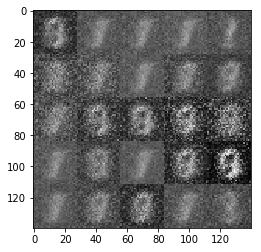

On the other hand, the model produces human-like images surprisingly quickly - after just 20 steps it looks remotely like a face:
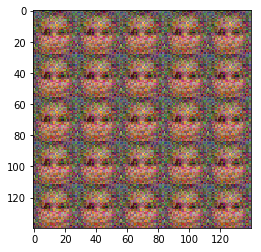

After some more training we get:
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 3.7918 Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 4.0924 Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 3.6120 Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 4.0936 Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 5.5772 Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 3.6756 Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 6.3590 Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 2.5974 Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 3.2055 Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 4.4034

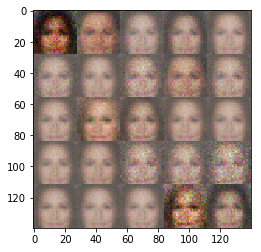

With just one hidden layer!

Can we do better? The first idea is to use two hidden layers - to make the model more complex. It helps, to some extent


The nice thing is that to change the model I just need to change two functions - generator and discriminator. Then I can run the code. Two 'dense' layers:

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    n_units=128
    alpha=0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        images_flat = tf.contrib.layers.flatten(images)
        h1 = tf.layers.dense(images_flat, 4*n_units, activation=None)
        
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Second hidden layer:
        h2 = tf.layers.dense(h1, n_units, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        logits = tf.layers.dense(h2, 1, activation=None)
        
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.01
    n_units=128
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Second hidden layer:
        h2 = tf.layers.dense(h1, 4*n_units, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        # Logits and tanh output
        logits = tf.layers.dense(h2, 28*28*out_channel_dim, activation=None)
        out_flat = tf.tanh(logits)
        out = tf.reshape(out_flat, shape = [tf.shape(out_flat)[0], 28, 28, out_channel_dim])
        
        return out
    
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [ ]:
tf.reset_default_graph()

batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.9

# alpha = 0.01

epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

The outcome with MNIST is just marginally better:
Epoch 2/3... Discriminator Loss: 0.7024... Generator Loss: 5.9389 Epoch 2/3... Discriminator Loss: 0.4611... Generator Loss: 8.6911 Epoch 2/3... Discriminator Loss: 0.7713... Generator Loss: 6.4877 Epoch 2/3... Discriminator Loss: 2.0381... Generator Loss: 4.6061 Epoch 2/3... Discriminator Loss: 1.7845... Generator Loss: 3.6589 Epoch 2/3... Discriminator Loss: 1.3071... Generator Loss: 1.1145 Epoch 2/3... Discriminator Loss: 0.6616... Generator Loss: 1.8757 Epoch 2/3... Discriminator Loss: 0.6133... Generator Loss: 2.7442 Epoch 2/3... Discriminator Loss: 0.6923... Generator Loss: 2.7735 Epoch 2/3... Discriminator Loss: 0.7211... Generator Loss: 3.1299

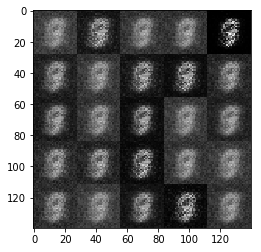

In [ ]:
tf.reset_default_graph()

batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Some faces start to look more or less realistic while others are more appropriate for horror movies:

Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 3.2185 Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 4.1808 Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 3.0244 Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.8627 Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 2.6573 Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 2.9110 Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 3.9304 Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.2237 Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.8739 Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 3.3397

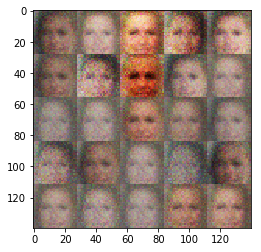

Can we stop here? The rubric does not give any reasonable criteria on where to stop. It just says:

all tests passed/ all functions properly implemented/ "The project generates realistic faces. It should be obvious that images generated look like faces."

What does it mean - "look like"?

A Russian proverb pops into my mind:
A hog looks like a hedgehog, but with different bustles.

In principle, the above images look like human faces, but can we do better?

We had a whole lecture on DCGANs. Now is the time for them!

I know about suggestions (in the forum) to do the project with a four layer Net.
But I'll start from just two convolutional layers.

It's easier to train (less time), so I can fine tune the parameters better and get a feeling of their relative importance.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*128)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x64 now
        
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 4, strides=4, padding='same')
        # 28x28x(3 or 1) now
        
        out = tf.tanh(logits)
        
        return out
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 64, 4, strides=4, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 7x7x64
        
                
        x3 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x128
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
        
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [ ]:
tf.reset_default_graph()

batch_size = 128
z_dim = 256
learning_rate = 0.00075
beta1 = 0.5

# alpha=0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Well, it looks like some hand-written signs, but not digits. We need 11 epochs to produce (with these parameters) something good:

Epoch 11/12... Discriminator Loss: 0.3321... Generator Loss: 3.5459 Epoch 11/12... Discriminator Loss: 0.3796... Generator Loss: 2.8495 Epoch 11/12... Discriminator Loss: 0.3382... Generator Loss: 2.8517 Epoch 11/12... Discriminator Loss: 0.3123... Generator Loss: 2.8906 Epoch 12/12... Discriminator Loss: 0.3607... Generator Loss: 2.4493 Epoch 12/12... Discriminator Loss: 0.2924... Generator Loss: 3.1735 Epoch 12/12... Discriminator Loss: 0.3263... Generator Loss: 2.6983 Epoch 12/12... Discriminator Loss: 0.3968... Generator Loss: 2.1776 Epoch 12/12... Discriminator Loss: 0.2948... Generator Loss: 3.0987 Epoch 12/12... Discriminator Loss: 0.4321... Generator Loss: 1.9879

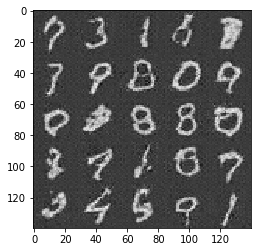

Already with 2 convolutional layers we learn that 2 epochs for MNIST is not enough!

In [ ]:
tf.reset_default_graph() # just in case!

#with the same parameters as for digits:
batch_size = 128
z_dim = 256
learning_rate = 0.00075
beta1 = 0.5

# alpha=0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Probably these are the best images which were produced by a Net with 2 conv layers ( some are best for horror movies):

Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.3550 Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.9441 Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.8528 Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.6914 Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.7421 Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 0.9657 Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.2887 Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 1.1488 Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.7347 Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.9515

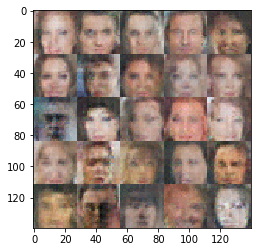

Two epochs are definitely not enough!

Now three convoulutional layers:

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(3 or 1) now
        
        out = tf.tanh(logits)
        
        return out
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
        
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [ ]:
tf.reset_default_graph() # just in case!

batch_size = 128
z_dim = 1024 # I use large z_dim to make a rich enough choice for the generator. The model is not very sensitive to this parameter
# but z_dim cannot be ridiculously small like z_dim = 4  
learning_rate = 0.00075
beta1 = 0.5

# alpha=0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Some images look very nice like hand-written signs. But they are not very close to digits. Probably the DCGAN learned hand-writing. No one explained it the difference between digits , letters and scribbles.

Epoch 4/4... Discriminator Loss: 0.7810... Generator Loss: 1.3899 Epoch 4/4... Discriminator Loss: 0.7013... Generator Loss: 1.5214 Epoch 4/4... Discriminator Loss: 0.9389... Generator Loss: 0.9426 Epoch 4/4... Discriminator Loss: 0.5983... Generator Loss: 1.7794 Epoch 4/4... Discriminator Loss: 0.5559... Generator Loss: 1.9410 Epoch 4/4... Discriminator Loss: 0.4978... Generator Loss: 2.3382 Epoch 4/4... Discriminator Loss: 0.3974... Generator Loss: 3.2933 Epoch 4/4... Discriminator Loss: 0.4142... Generator Loss: 2.9765 Epoch 4/4... Discriminator Loss: 0.4707... Generator Loss: 2.8614 Epoch 4/4... Discriminator Loss: 0.5535... Generator Loss: 1.8034

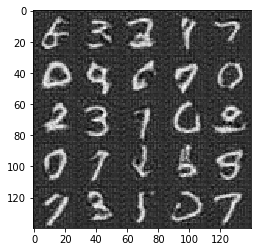

In [ ]:
tf.reset_default_graph() # just in case!

batch_size = 128
z_dim = 1024
learning_rate = 0.00075
beta1 = 0.5

# alpha=0.1
# three convolutional layers in the DCGAN

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.6131 Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 1.7055 Epoch 2/2... Discriminator Loss: 1.9337... Generator Loss: 0.2792 Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.8765 Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5864 Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.5563 Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.4936 Epoch 2/2... Discriminator Loss: 1.5598... Generator Loss: 0.4822 Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4891 Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.9436

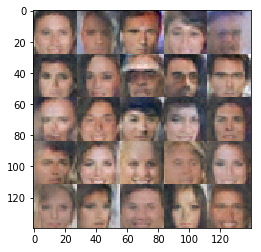

Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.7077 Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.7029 Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 0.6485 Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.6901 Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.2250 Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 1.4212 Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.6859 Epoch 2/2... Discriminator Loss: 1.1016... Generator Loss: 1.1138 Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.5208 Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 1.8611

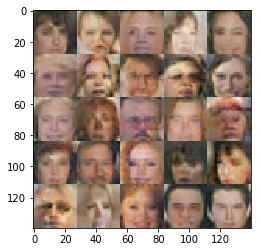

Now is time for a DCGAN with four conv layers. It should be great to fine tune the parameters as I see no reason at all why parameters tuned for a DCGAN with 2 conv layers should fit well DCGANs with three and even four conv layers. However, it will take ages to train all the models needed for fine-tuning. So I just use the old parameters and hope for the best. Let's see what comes out!

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x0 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 2, 2, 512))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # 2x2x512 now
        
        x1 = tf.layers.conv2d_transpose(x0, 256, 5, strides=2, padding='same')       
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(3 or 1) now
        
        out = tf.tanh(logits)
        
        return out
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 4, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
        
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [ ]:
tf.reset_default_graph() 

batch_size = 128
z_dim = 1024
learning_rate = 0.00075
beta1 = 0.5

# alpha=0.1
# four convolutional layers in the DCGAN

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

OK. After two epochs we don't see much improvement in image quality - they are still blurry compared to the originals. But still many of them are recognizable as faces:

Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 1.7237 Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 4.2152 Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.8313 Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.7456 Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 2.0026 Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.0259 Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 2.3098 Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 2.1831 Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.8559 Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.0231

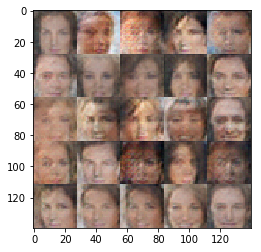

Probably after 5-6 epochs we can hope for something better. But already this exercise pushed my laptop to its limits. Fine tuning of hyper parameters for both DCGANs with 3 and 4 convolutional layers is needed, but for 4-layer Net it seems hardly possible with my current laptop.

One more sample of images from the latest exercise:

Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 5.3000 Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.4901 Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.8557 Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.1505 Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.3727 Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 2.0562 Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 2.1450 Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.0503 Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 2.5465 Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.3651

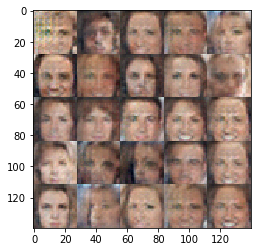